In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from regression_ViT import regression_ViT as ViT 

import torch 
import torch.nn as nn

from sklearn.preprocessing import StandardScaler

In [1]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 6.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 992.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 6.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 2.0 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.2 MB/s eta 0:00:0000:01
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143860 sha256=fbba2b4ceffce0e6926b2

## Data

In [35]:
df = pd.read_csv('EjemploDatos.csv', header=0)
df

,prediction date,"10u_(44.0, -9.5)","10u_(44.0, -9.375)","10u_(44.0, -9.25)","10u_(44.0, -9.125)","10u_(44.0, -9.0)","10u_(44.0, -8.875)","10u_(44.0, -8.75)","10u_(44.0, -8.625)","10u_(44.0, -8.5)",...,"vel100_(42.875, -6.0)","vel100_(43.0, -6.0)","vel100_(43.125, -6.0)","vel100_(43.25, -6.0)","vel100_(43.375, -6.0)","vel100_(43.5, -6.0)","vel100_(43.625, -6.0)","vel100_(43.75, -6.0)","vel100_(43.875, -6.0)","vel100_(44.0, -6.0)"
0,2016-01-01 00:00:00,1.577097,1.675974,1.836863,1.821115,1.681467,1.424021,1.190012,1.106394,1.108713,...,4.542353,5.321404,5.971150,5.862873,5.164530,5.391425,6.107658,6.398007,6.472929,6.793221
1,2016-01-01 01:00:00,1.320722,1.059857,1.200238,1.276654,1.713910,1.246137,0.725141,0.203412,0.215253,...,4.708214,5.435709,6.092992,5.361253,3.485183,3.988883,4.845162,5.260955,5.464975,5.908251
2,2016-01-01 02:00:00,1.562336,1.023518,0.415607,0.335896,0.563801,0.696369,0.487873,0.106770,-0.157024,...,4.553245,5.325067,6.018884,4.991258,2.281320,2.807106,3.654994,4.170403,4.632105,5.078648
3,2016-01-01 03:00:00,0.198002,0.025639,0.332890,-0.118526,-0.533199,-1.093990,-1.123653,-1.040646,-0.928341,...,4.668390,5.177444,5.716941,4.493564,1.185751,1.837592,3.329041,4.260316,4.934864,5.643699
4,2016-01-01 04:00:00,1.604583,1.043792,1.073821,0.065032,-0.961823,-1.394685,-1.394074,-1.230012,-1.500520,...,4.791137,5.317643,5.648662,4.902998,3.442938,3.724846,4.111763,4.328406,4.885375,5.730442
5,2016-01-01 05:00:00,0.001539,-0.707567,-0.608324,-0.928026,-1.066332,-1.305223,-1.229540,-1.251390,-1.308153,...,4.950641,5.718382,6.536770,6.109400,5.129474,5.675023,6.329318,6.272207,6.162174,6.265856
6,2016-01-01 06:00:00,-2.131102,-2.594481,-2.936155,-3.301023,-3.431395,-3.205687,-2.967039,-2.780516,-2.367186,...,5.059935,6.261467,7.395229,7.328403,6.295951,6.854520,8.095615,8.362846,8.369309,8.521008
7,2016-01-01 07:00:00,-1.633602,-2.313046,-3.071835,-3.889706,-4.586483,-4.775936,-4.795467,-4.627987,-4.192196,...,5.133531,6.734069,8.169803,7.901614,6.135846,7.033442,8.644081,9.221421,9.505737,9.753907
8,2016-01-01 08:00:00,0.591620,-0.265557,-0.680596,-1.557061,-2.424249,-2.851739,-3.063897,-3.015557,-3.060723,...,5.980429,7.270196,8.254039,7.293384,4.044214,5.829247,7.635651,8.475030,9.303746,10.323868


In [3]:
df.describe()

,"10u_(44.0, -9.5)","10u_(44.0, -9.375)","10u_(44.0, -9.25)","10u_(44.0, -9.125)","10u_(44.0, -9.0)","10u_(44.0, -8.875)","10u_(44.0, -8.75)","10u_(44.0, -8.625)","10u_(44.0, -8.5)","10u_(44.0, -8.375)",...,"vel100_(42.875, -6.0)","vel100_(43.0, -6.0)","vel100_(43.125, -6.0)","vel100_(43.25, -6.0)","vel100_(43.375, -6.0)","vel100_(43.5, -6.0)","vel100_(43.625, -6.0)","vel100_(43.75, -6.0)","vel100_(43.875, -6.0)","vel100_(44.0, -6.0)"
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.343466,-0.116875,-0.270832,-0.699516,-1.004923,-1.251193,-1.352294,-1.392170,-1.354464,-1.143676,...,4.931986,5.840153,6.644941,6.027194,4.129468,4.793565,5.861476,6.305510,6.636802,7.113211
std,1.404674,1.524782,1.749342,1.936031,2.180241,2.122506,1.988303,1.811029,1.664325,1.587899,...,0.445986,0.745539,1.030375,1.223523,1.723564,1.800871,1.985498,1.974626,1.934979,1.928302
min,-2.131102,-2.594481,-3.071835,-3.889706,-4.586483,-4.775936,-4.795467,-4.627987,-4.192196,-3.778988,...,4.542353,5.177444,5.648662,4.493564,1.185751,1.837592,3.329041,4.170403,4.632105,5.078648
25%,0.001539,-0.707567,-0.680596,-1.557061,-2.424249,-2.851739,-2.967039,-2.780516,-2.367186,-1.895506,...,4.668390,5.321404,5.971150,4.991258,3.442938,3.724846,4.111763,4.328406,4.934864,5.730442
50%,0.591620,0.025639,0.332890,-0.118526,-0.961823,-1.305223,-1.229540,-1.230012,-1.308153,-1.094408,...,4.791137,5.435709,6.092992,5.862873,4.044214,5.391425,6.107658,6.272207,6.162174,6.265856
75%,1.562336,1.043792,1.073821,0.335896,0.563801,0.696369,0.487873,0.106770,-0.157024,-0.133709,...,5.059935,6.261467,7.395229,7.293384,5.164530,5.829247,7.635651,8.362846,8.369309,8.521008
max,1.604583,1.675974,1.836863,1.821115,1.713910,1.424021,1.190012,1.106394,1.108713,1.304880,...,5.980429,7.270196,8.254039,7.901614,6.295951,7.033442,8.644081,9.221421,9.505737,10.323868


In [36]:
# feature scale the data 
scaler = StandardScaler()
df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])


In [5]:
df.head()

,prediction date,"10u_(44.0, -9.5)","10u_(44.0, -9.375)","10u_(44.0, -9.25)","10u_(44.0, -9.125)","10u_(44.0, -9.0)","10u_(44.0, -8.875)","10u_(44.0, -8.75)","10u_(44.0, -8.625)","10u_(44.0, -8.5)",...,"vel100_(42.875, -6.0)","vel100_(43.0, -6.0)","vel100_(43.125, -6.0)","vel100_(43.25, -6.0)","vel100_(43.375, -6.0)","vel100_(43.5, -6.0)","vel100_(43.625, -6.0)","vel100_(43.75, -6.0)","vel100_(43.875, -6.0)","vel100_(44.0, -6.0)"
0,2016-01-01 00:00:00,0.931507,1.247131,1.277937,1.380935,1.306895,1.336860,1.356193,1.463327,1.569762,...,-0.926641,-0.738011,-0.693595,-0.142448,0.636965,0.352122,0.131511,0.049684,-0.089827,-0.176010
1,2016-01-01 01:00:00,0.737919,0.818552,0.891939,1.082650,1.322678,1.247967,1.108207,0.934480,1.000367,...,-0.532182,-0.575394,-0.568173,-0.577298,-0.396485,-0.473934,-0.542919,-0.561077,-0.642338,-0.662787
2,2016-01-01 02:00:00,0.920361,0.793273,0.416202,0.567253,0.763164,0.973237,0.981637,0.877880,0.763118,...,-0.900737,-0.732801,-0.644458,-0.898043,-1.137327,-1.169966,-1.178710,-1.146862,-1.098876,-1.119109
3,2016-01-01 03:00:00,-0.109839,0.099134,0.366048,0.318297,0.229487,0.078557,0.121968,0.205876,0.271565,...,-0.626893,-0.942820,-0.955277,-1.329489,-1.811527,-1.740981,-1.352836,-1.098565,-0.932918,-0.808304
4,2016-01-01 04:00:00,0.952261,0.807376,0.815290,0.418860,0.020967,-0.071706,-0.022288,0.094971,-0.093080,...,-0.334974,-0.743363,-1.025562,-0.974554,-0.422482,-0.629444,-0.934703,-1.061991,-0.960045,-0.760591


In [6]:
# print unique column names starting with '10u_'
for col in df.columns:
    if col.startswith('vel100_'):
        print(col)

vel100_(42.25, -9.5)
vel100_(42.375, -9.5)
vel100_(42.5, -9.5)
vel100_(42.625, -9.5)
vel100_(42.75, -9.5)
vel100_(42.875, -9.5)
vel100_(43.0, -9.5)
vel100_(43.125, -9.5)
vel100_(43.25, -9.5)
vel100_(43.375, -9.5)
vel100_(43.5, -9.5)
vel100_(43.625, -9.5)
vel100_(43.75, -9.5)
vel100_(43.875, -9.5)
vel100_(44.0, -9.5)
vel100_(42.25, -9.375)
vel100_(42.375, -9.375)
vel100_(42.5, -9.375)
vel100_(42.625, -9.375)
vel100_(42.75, -9.375)
vel100_(42.875, -9.375)
vel100_(43.0, -9.375)
vel100_(43.125, -9.375)
vel100_(43.25, -9.375)
vel100_(43.375, -9.375)
vel100_(43.5, -9.375)
vel100_(43.625, -9.375)
vel100_(43.75, -9.375)
vel100_(43.875, -9.375)
vel100_(44.0, -9.375)
vel100_(42.25, -9.25)
vel100_(42.375, -9.25)
vel100_(42.5, -9.25)
vel100_(42.625, -9.25)
vel100_(42.75, -9.25)
vel100_(42.875, -9.25)
vel100_(43.0, -9.25)
vel100_(43.125, -9.25)
vel100_(43.25, -9.25)
vel100_(43.375, -9.25)
vel100_(43.5, -9.25)
vel100_(43.625, -9.25)
vel100_(43.75, -9.25)
vel100_(43.875, -9.25)
vel100_(44.0, -9.25)
v

The EjemploDatos.csv contains 3481 columns that can be divided into: 
 - Prediction Date : day and hour 
 
 - 10u             : u component at height 10m
  
 - 10v             : v component at height 10m
 
 - 2t              : temperature at height 2m
 
 - sp              : pressure at surface
 
 - 100u            : u component at height 100m
 
 - 100v            : v component at height 100m
 
 - vel10           : module of the wind at height 10m
 
 - vel100          : module of the wind at height 100m
 

## Target

Observed production at Prediction Date (MWh)

Potencia máxima del parque: 17560Kwh (los datos, ya confirmado, están en Kwh

In [37]:
target_df = pd.read_csv('EjemploTarget.csv',
                        header=None)
target_df.head()

,0,1
0,2016-01-01 00:00:00,4126.70
1,2016-01-01 01:00:00,5688.51
2,2016-01-01 02:00:00,7742.01
3,2016-01-01 03:00:00,7660.50
4,2016-01-01 04:00:00,9730.48


In [8]:
target_df[1]

0     4126.70
1     5688.51
2     7742.01
3     7660.50
4     9730.48
5     9771.57
6     8619.96
7     9886.56
8    13056.48
Name: 1, dtype: float64

### Coordinates of interest

![Map](./figures/mapa.png)

In [9]:
# coordinates of interest
coordenates_of_interest_1 = ['prediction date',

                            '(43.875, -8.375)', '(43.75, -8.375)', '(43.625, -8.375)', '(43.5, -8.375)', '(43.375, -8.375)', '(43.25, -8.375)', '(43.125, -8.375)', '(43.0, -8.375)', '(42.875, -8.375)',

                            '(43.875, -8.25)', '(43.75, -8.25)', '(43.625, -8.25)', '(43.5, -8.25)', '(43.375, -8.25)', '(43.25, -8.25)', '(43.125, -8.25)', '(43.0, -8.25)', '(42.875, -8.25)',
                            
                            '(43.875, -8.125)', '(43.75, -8.125)', '(43.625, -8.125)', '(43.5, -8.125)', '(43.375, -8.125)', '(43.25, -8.125)', '(43.125, -8.125)', '(43.0, -8.125)', '(42.875, -8.125)',

                           '(43.875, -8.0)', '(43.75, -8.0)', '(43.625, -8.0)', '(43.5, -8.0)', '(43.375, -8.0)', '(43.25, -8.0)', '(43.125, -8.0)', '(43.0, -8.0)', '(42.875, -8.0)',
                        
                           '(43.875, -7.875)','(43.75, -7.875)','(43.625, -7.875)','(43.5, -7.875)','(43.375, -7.875)','(43.25, -7.875)','(43.125, -7.875)','(43.0, -7.875)','(42.875, -7.875)',

                            '(43.875, -7.75)','(43.75, -7.75)','(43.625, -7.75)','(43.5, -7.75)','(43.375, -7.75)','(43.25, -7.75)','(43.125, -7.75)','(43.0, -7.75)','(42.875, -7.75)',

                            '(43.875, -7.625)','(43.75, -7.625)','(43.625, -7.625)','(43.5, -7.625)','(43.375, -7.625)','(43.25, -7.625)','(43.125, -7.625)','(43.0, -7.625)','(42.875, -7.625)',

                            '(43.875, -7.5)','(43.75, -7.5)','(43.625, -7.5)','(43.5, -7.5)','(43.375, -7.5)','(43.25, -7.5)','(43.125, -7.5)','(43.0, -7.5)','(42.875, -7.5)',

                            '(43.875, -7.375)','(43.75, -7.375)','(43.625, -7.375)','(43.5, -7.375)','(43.375, -7.375)','(43.25, -7.375)','(43.125, -7.375)','(43.0, -7.375)','(42.875, -7.375)',
                            
                           ]

In [10]:
coordinates_of_interest = ['prediction date']

for lat in np.arange(43.875, 42.875-0.125, -0.125):
    for lon in np.arange(-8.375, -7.375+0.125, 0.125):
        coordinates_of_interest.append(f'({lat}, {lon})')

In [11]:
# check if coordinates_of_interest and coordenates_of_interest_1 have the same elements
print(set(coordinates_of_interest) == set(coordenates_of_interest_1))

# print the elements that are not in coordinates_of_interest
print(set(coordenates_of_interest_1) - set(coordinates_of_interest))

True
set()


In [12]:
len(coordinates_of_interest)

82

In [13]:
len(coordenates_of_interest_1)

82

In [15]:
# keep columns that contain any of the coordinates of interest
df = df.loc[:, df.columns.str.contains('|'.join(coordinates_of_interest))]

/var/folders/_z/8tjgjv9d62qfwnfqwr1z6yl00000gq/T/ipykernel_57732/3124318484.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df.loc[:, df.columns.str.contains('|'.join(coordinates_of_interest))]


The resulting data has the same dimension as the data used in the paper "Deep Learning Applied to Wind Power Forecasting: a Spatio-Temporal Approach" fed to the Vision Transformer. 

## Extended coordinates of interest

In [38]:
MAX_LAT = 44.0
MIN_LAT = 42.25
MAX_LON = -6.125
MIN_LON = -9.375

In [39]:
coordinates_of_interest = ['prediction date']

for lat in np.arange(MAX_LAT, MIN_LAT-0.125, -0.125):
    print(lat)
    for lon in np.arange(MIN_LON, MAX_LON+0.125, 0.125):
        coordinates_of_interest.append(f'({lat}, {lon})')


44.0
43.875
43.75
43.625
43.5
43.375
43.25
43.125
43.0
42.875
42.75
42.625
42.5
42.375
42.25


In [40]:
len(coordinates_of_interest)

406

All coordinates (29*15) + prediction date = 435 + 1

Almost all (27*15) + 1 = 405 +1

### Creating multi-channel images (8 channels x9x9) as tensors

In [41]:
df = df.loc[:, df.columns.str.contains('|'.join(coordinates_of_interest))]

/var/folders/_z/8tjgjv9d62qfwnfqwr1z6yl00000gq/T/ipykernel_57732/986922646.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df.loc[:, df.columns.str.contains('|'.join(coordinates_of_interest))]


In [42]:
channels = ['10u', '10v', '2t', 'sp', '100u', '100v', 'vel10_', 'vel100']

image = []

for channel in channels: 
    image.append(df.loc[0, df.columns.str.contains(channel)].values.reshape(15,27))

# transform image to tensor
image = torch.tensor(np.array(image, dtype=np.float32)).permute(1,2,0)
image.shape

torch.Size([15, 27, 8])

Prediction date 2016-01-01 00:00:00


Text(0.5, 1.0, '2t')

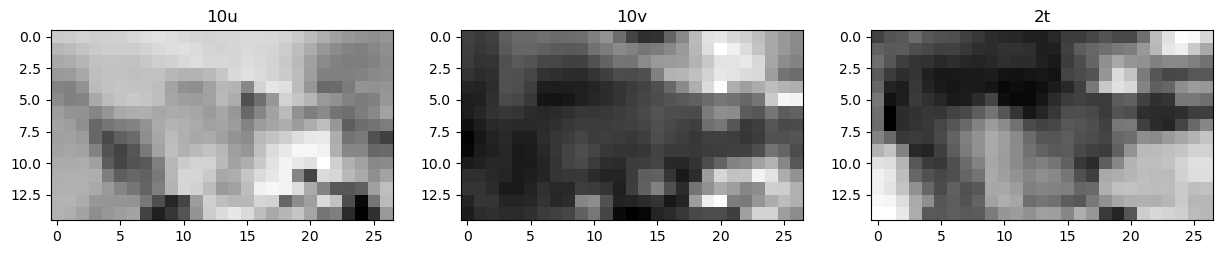

In [43]:
print('Prediction date 2016-01-01 00:00:00')

# subplot with 1x3 grid
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# plot images
ax[0].imshow(image[:,:,0],cmap='gray')
ax[1].imshow(image[:,:,1],cmap='gray')
ax[2].imshow(image[:,:,2],cmap='gray')

# set titles
ax[0].set_title('10u')
ax[1].set_title('10v')
ax[2].set_title('2t')

### Pytorch dataset 

In [59]:
def get_data_and_target_of_interest(df, target_df, coordenates_of_interest, channels):
    """
    Returns data of interest from df and target_df

    Parameters
    ----------
    df : pandas dataframe
        Dataframe with all the data.
    target_df : pandas dataframe
        Dataframe with all the targets.
    coordenates_of_interest : list
        List with the coordinates of interest.
    channels : list
        List with the channel names to build the image.
    
    Returns
    -------
    data_of_interest : torch tensor
        Tensor with all the images of the coordinates of interest.
    target_of_interest : torch tensor
        Tensor with the target of interest.

    """
    # keep columns that contain any of the coordinates of interest
    df = df.loc[:, df.columns.str.contains('|'.join(coordenates_of_interest))]
    print(df.shape)

    # get data of interest
    data_of_interest = []
    for i in range(df.shape[0]):
        image = []
        for channel in channels: 
            image.append(df.loc[i, df.columns.str.contains(channel)].values.reshape(15,27))
        data_of_interest.append(image)
    
    # transform data to tensor
    data_of_interest = torch.tensor(np.array(data_of_interest, dtype=np.float32))
    
    # get target of interest
    target_of_interest = torch.tensor(np.array(target_df[1].values, dtype=np.float32))
        
    return target_of_interest, data_of_interest

In [41]:
df1 = df.filter(regex='|'.join(coordenates_of_interest))
df2 = df.loc[:, df.columns.str.contains('|'.join(coordenates_of_interest))]

/var/folders/_z/8tjgjv9d62qfwnfqwr1z6yl00000gq/T/ipykernel_2118/1517760462.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df2 = df.loc[:, df.columns.str.contains('|'.join(coordenates_of_interest))]


In [44]:
def create_images(df, channels, image_size):
    """
    Creates images from the data in df.

    Parameters
    ----------
    df : pandas dataframe
        Dataframe with all the data.
    channels : list
        List with the channel names to build the image.
    image_size : int
        Size of the image.

    Returns
    -------
    images : torch tensor
        Shape: (n_samples, n_channels, image_size, image_size)
        Tensor with all the images of the coordinates of interest.

    """
    images = np.zeros((df.shape[0], len(channels), image_size, image_size), dtype=np.float32)

    for i, channel in enumerate(channels):
        channel_data = df.filter(regex=channel).values.reshape(df.shape[0], image_size, image_size)
        images[:, i, :, :] = channel_data

    return torch.from_numpy(images)

In [14]:
def chat(df, target_df, coordenates_of_interest, channels, normalize_target=False, INSTALLED_POWER=17500):
    """
    Returns data of interest from df and target_df

    Parameters
    ----------
    df : pandas dataframe
        Dataframe with all the data.
    target_df : pandas dataframe
        Dataframe with all the targets.
    coordenates_of_interest : list
        List with the coordinates of interest.
    channels : list
        List with the channel names to build the image.
    normalize_target : bool, optional
        If True, the target is normalized dividing by the maximum power. The default is False.
    
    Returns
    -------
    data_of_interest : torch tensor
        Shape: (n_samples, n_channels, 9, 9)
        Tensor with all the images of the coordinates of interest.
    target_of_interest : torch tensor
        Shape: (n_samples)
        Tensor with the target of interest.

    """
    # filter out unwanted columns from the data
    df = df.filter(regex='|'.join(coordenates_of_interest))
    print(df.shape)

    # create images
    data_of_interest = create_images(df, channels, image_size=9)
    
    # normalize target if needed
    target = target_df[1].values.astype(np.float32)
    if normalize_target:
        target /= INSTALLED_POWER

    return data_of_interest, torch.from_numpy(target)

In [57]:
images, labels = chat(df, target_df, coordinates_of_interest, channels, normalize_target=True)

(9, 3241)


ValueError: cannot reshape array of size 3645 into shape (9,9,9)

In [73]:
df = pd.read_csv('EjemploDatos.csv')
target_df = pd.read_csv('EjemploTarget.csv', header=None)

target_of_interest, data_of_interest = get_data_and_target_of_interest(df, target_df, coordenates_of_interest, channels)
new_data_of_interest, new_target_of_interest = chat(df, target_df, coordenates_of_interest, channels)

#checl if the results are the same
print(torch.all(torch.eq(data_of_interest, new_data_of_interest)))
print(torch.all(torch.eq(target_of_interest, new_target_of_interest)))

/var/folders/_z/8tjgjv9d62qfwnfqwr1z6yl00000gq/T/ipykernel_2118/1419458357.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df.loc[:, df.columns.str.contains('|'.join(coordenates_of_interest))]


(9, 649)
(9, 649)
tensor(True)
tensor(True)


In [45]:
def create_images_with_all_coordinates(df, channels):
    """
    Creates images from the data in df.

    Parameters
    ----------
    df : pandas dataframe
        Dataframe with all the data.
    channels : list
        List with the channel names to build the image.

    Returns
    -------
    images : torch tensor
        Shape: (n_samples, n_channels, 15, 27)
        Tensor with all the images of the coordinates of interest.

    """
    images = np.zeros((df.shape[0], len(channels), 15, 27), dtype=np.float32)

    for i, channel in enumerate(channels):
        channel_data = df.filter(regex=channel).values.reshape(df.shape[0], 15, 27)
        images[:, i, :, :] = channel_data

    return torch.from_numpy(images)

def get_data_and_target_with_all_coordinates(df, target_df, coordenates_of_interest, channels, normalize_target=False, INSTALLED_POWER=17500):
    """
    Returns data of interest from df and target_df

    Parameters
    ----------
    df : pandas dataframe
        Dataframe with all the data.
    target_df : pandas dataframe
        Dataframe with all the targets.
    coordenates_of_interest : list
        List with the coordinates of interest.
    channels : list
        List with the channel names to build the image.
    normalize_target : bool, optional
        If True, the target is normalized dividing by the maximum power. The default is False.
    
    Returns
    -------
    data_of_interest : torch tensor
        Shape: (n_samples, n_channels, 15, 27)
        Tensor with all the images of the coordinates of interest.
    target_of_interest : torch tensor
        Shape: (n_samples)
        Tensor with the target of interest.

    """
    # filter out unwanted columns to keep only the coordinates of interest
    df = df.filter(regex='|'.join(coordenates_of_interest))

    # create images
    data_of_interest = create_images_with_all_coordinates(df, channels)
    
    # normalize target if needed
    target = target_df[1].values.astype(np.float32)
    if normalize_target:
        target /= INSTALLED_POWER

    return data_of_interest, torch.from_numpy(target)

In [46]:
image, labels = get_data_and_target_with_all_coordinates(df, target_df, coordinates_of_interest, channels, normalize_target=False)

In [47]:
# shape of image 
image.shape

torch.Size([9, 8, 15, 27])

In [48]:
from torch.utils.data import Dataset, DataLoader

In [57]:
data, labels = get_data_and_target_with_all_coordinates(df, target_df, coordinates_of_interest, channels)

trainset = torch.utils.data.TensorDataset(data, labels)

In [58]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True)

In [59]:
model = ViT(image_size=27, 
        patch_size=3, 
        channels=8,
        dim=64, 
        depth=2, 
        heads=2, 
        mlp_dim=128)

In [60]:
# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 2
n_total_steps = len(trainloader)

# train the network
for epoch in range(num_epochs):  # loop over the dataset multiple times

    print(f"Epoch {epoch+1} of {2}")

    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        labels = labels.unsqueeze(1).float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # print dimensions
        print(f"inputs shape: {inputs.shape}")
        print(f"labels shape: {labels.shape}")

        # forward + backward + optimize
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
     
        # verbosity 
        print(f'epoch {epoch+1}/{num_epochs}; step {i+1}/{n_total_steps}, loss={loss.item():.4f}') 
    
     
print('Finished Training')

Epoch 1 of 2
inputs shape: torch.Size([2, 8, 15, 27])
labels shape: torch.Size([2, 1])
epoch 1/2; step 1/5, loss=77080440.0000
inputs shape: torch.Size([2, 8, 15, 27])
labels shape: torch.Size([2, 1])
epoch 1/2; step 2/5, loss=15746482.0000
inputs shape: torch.Size([2, 8, 15, 27])
labels shape: torch.Size([2, 1])
epoch 1/2; step 3/5, loss=370481530284307135965691904.0000
inputs shape: torch.Size([2, 8, 15, 27])
labels shape: torch.Size([2, 1])
epoch 1/2; step 4/5, loss=nan
inputs shape: torch.Size([1, 8, 15, 27])
labels shape: torch.Size([1, 1])
epoch 1/2; step 5/5, loss=nan
Epoch 2 of 2
inputs shape: torch.Size([2, 8, 15, 27])
labels shape: torch.Size([2, 1])
epoch 2/2; step 1/5, loss=nan
inputs shape: torch.Size([2, 8, 15, 27])
labels shape: torch.Size([2, 1])
epoch 2/2; step 2/5, loss=nan
inputs shape: torch.Size([2, 8, 15, 27])
labels shape: torch.Size([2, 1])
epoch 2/2; step 3/5, loss=nan
inputs shape: torch.Size([2, 8, 15, 27])
labels shape: torch.Size([2, 1])
epoch 2/2; step 4/5

: 